## Data Analysys Project: Analysis of Isekai Sub-Genre Growth (2000 - 2024)

### 11. Resuming
In the previous two notebooks we confirmed, observed, and quantified the growth and representation of the isekai sub-genre.

### 12. Introduction and objectives
In this notebook we are going to examine **one** of the possible reasons for that growth: **original source expansion**. It's possible that one of the reasons for the observed growth in the isekai sub-genre is a considerable increase in the original sources, primarily **manga** and **light novels**.

**Objectives:**
- Quantify the proportion of isekai anime derived from different source materials
- Analyze the trend in anime adaptations from manga and light novel sources
- Investigate whether there's a correlation between source material growth and isekai anime production

### 13. Dataset Description:
For this notebooks in adition to *Animes [1962-2024]*, we will use also two differents data frames, one for **mangas** and other for **light novels**.

**Light novel:** 

*Data Source:* novel-dataset by shaido987, granted explicit permission to use his dataset

*Source:* [GitHub](https://github.com/shaido987/novel-dataset)

**Manga:**

*Data Source:* MyanimeList Anime & Manga Dataset (July 2025) by Hamza Ashfaq, licensed under MIT

*Source:* [Kaggle](https://www.kaggle.com/datasets/hamzaashfaque1999/myanimelist-scraped-data)

*License:* [MIT](https://www.mit.edu/~amini/LICENSE.md)

### 14. Import and Enviroment Setup

In [262]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
import sys

sys.path.append("../")
pd.set_option("display.max_rows", None)

from src import helpers

### 15. Data Loading

In [263]:
novel_path = "../data/novels_0.1.5.csv"
manga_path = "../data/manga_entries.csv"

anime_df, ianime_df = helpers.cidf(["Title", "Release", "Theme", "Source"])
novel_df = pd.read_csv(novel_path, usecols=[1,2,5,8,9])
manga_df = pd.read_csv(manga_path, usecols=[2,19,23])

### 16. Data Cleaning and Filtering

#### Novels

Since we are focusing in the anime industry only novels from Japan, China and South Korea will be used, as well as only the ones relased between 2000 and 2024. In addition, should any tag be empty, then its row will be removed

In [264]:
countries = ["Japanese", "Chinese", "Korean"]

novel_df = novel_df[novel_df["original_language"].str.lower().isin([c.lower()for c in countries])]

novel_df = novel_df.dropna(subset=["start_year"])
novel_df["start_year"] = novel_df["start_year"].str.replace(r"[^\d]", "", regex=True)

novel_df["start_year"] = pd.to_numeric(novel_df["start_year"])
novel_df = novel_df[(novel_df["start_year"] > 1999) & (novel_df["start_year"] < 2025)]

novel_df["tags"] = novel_df["tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

novel_df = novel_df[novel_df["tags"].apply(lambda x: len(x) > 0)]

Only *Web Novels* and *Light Novels* will be take into account for this analysis, due to their **major relevance** in the anime industry. Duplicates will be removed as well to ensure that the same work is not counted twice.

In [265]:
types = ["Web novel", "Light novel"]

novel_df = novel_df[novel_df["novel_type"].str.lower().isin([c.lower() for c in types])]

duplicates = novel_df["name"].str.lower().duplicated().sum()
print(f"There are {duplicates} duplicates in the data frame")

novel_df = novel_df.drop_duplicates(subset="name")

There are 9 duplicates in the data frame


#### Mangas
All mangas without theme will be removed and as usual only mangas from 2000 to 2024 will be included. Also, the dulpicates rows will be removed.

In [266]:
manga_df["themes"] = manga_df["themes"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

manga_df = manga_df[manga_df["themes"].apply(lambda x: len(x) > 0)]

manga_df["publishing_date"] = (
    manga_df["publishing_date"]
    .str.extract(r'([A-Za-z]{3}\s+\d{1,2},\s+\d{4}|\d{4})', expand=False)
    .pipe(pd.to_datetime, errors="coerce")
)

manga_df = manga_df.dropna(subset="publishing_date")

manga_df = manga_df[(manga_df["publishing_date"].dt.year > 1999) & (manga_df["publishing_date"].dt.year < 2025)]

duplicates = manga_df["title_name"].str.lower().duplicated().sum()
print(f"There are {duplicates} mangas duplicated")

manga_df = manga_df.drop_duplicates(subset="title_name")

There are 744 mangas duplicated


### 17. Data Frames
This time, in addition to `ianime_df` (prior isekai_df), we will also use `inovel_df` (for isekai in novels), and `imanga_df` (for isekai in mangas).

**inovel_df**

In [267]:
tags_novel =["transported to another world", "reincarnated in another world", "reincarnated in a game world", "transported into a game world", "parallel worlds"]

inovel_df = novel_df[novel_df["tags"].apply(lambda x: any(tag.lower() in [t.lower() for t in tags_novel] for tag in x))]

**imanga_df**

In [268]:
imanga_df = manga_df[manga_df["themes"].apply(lambda x: "isekai" in [theme.lower() for theme in x])]

### 18. Analysis
First off, we'll explore the most common sources for isekai anime.

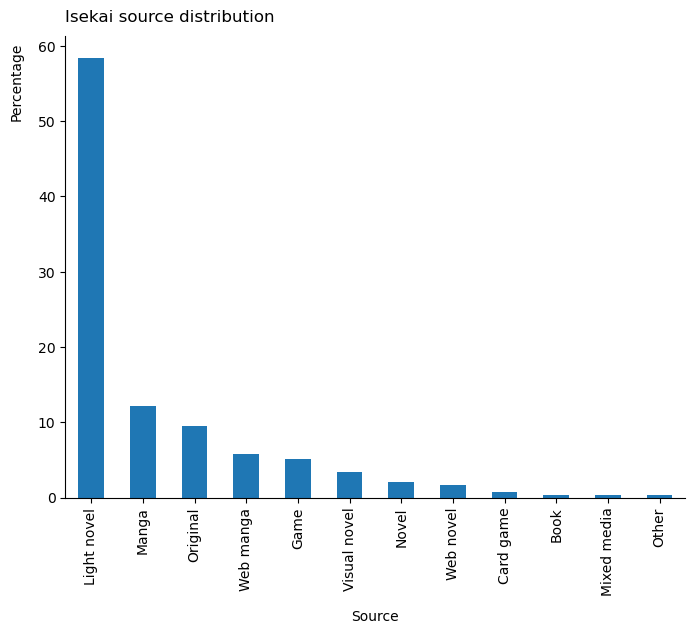

In [269]:
source_count = ianime_df.groupby("Source")["Source"].value_counts().sort_values(ascending=False) / len(ianime_df) * 100

plt.figure(figsize=(8,6))
source_count.plot(kind="bar")

plt.title("Isekai source distribution", loc="left", fontsize=12, pad=10)
plt.ylabel("Percentage", y=0.9, labelpad=10, fontsize=10)
plt.xlabel("Source", labelpad=10, fontsize=10)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()

**Note:** Although web novels are generally considered an insignificant source for the isekai sub-genre, as shown in the chart where light novels are the dominant source and web novels have a minimal impact, the `novel-dataset` pulls information from *Novel Updates*. This site categorizes many novels as web novels, even though they may also have a light novel version. It's often the light novel version that is adapted into anime.

A good example of this is *Honzuki no Gekokujou*, which is labeled as a web novel, even though it also has a light novel. For this reason, we will continue to include web novels from `inovel_df` in our analysis.

**Observation:** Clearly Light Novel is the most relevant source for the isekai sub-genre, followed by manga and original work.

**Next step:** Observe and quantify the growth of the Isekai in the novels and compare to the industry itself.

In [270]:
novel_count = novel_df.groupby("start_year")["start_year"].value_counts().sort_index()
inovel_count = inovel_df.groupby("start_year")["start_year"].value_counts()
inovel_count.loc[2002] = 0
inovel_count = inovel_count.sort_index()

groups = (novel_count.index // 5 * 5)

novel_count_5 = novel_count.groupby(groups).sum()
inovel_count_5 = inovel_count.groupby(groups).sum()

novel_growth = helpers.cgp(novel_count_5.values[0], novel_count_5.values[-1])
inovel_growth = helpers.cgp(inovel_count_5.values[0], inovel_count_5.values[-1])

print(f"The novel industry has grown by {novel_growth}% when comparing the periods 2000-2004 and 2020-2024, and the sub-genre isekai by {inovel_growth}% when comparing the same periods")

The novel industry has grown by 19400.0% when comparing the periods 2000-2004 and 2020-2024, and the sub-genre isekai by 61975.0% when comparing the same periods


**Observation:** The isekai sub-genre once again outpacing its industry shows that it has not only become relevant in the anime format, but also in the novel industry. Both seem to have gone from niche to dominant. This leads us to a question: did it first become relevant in anime and then novel, or was it the other way around?

**Next step:** We are going to compare the growth of both industries, anime and novel, and the sub-genres in both of them to see if they follow a similar trend or if one follows the other.

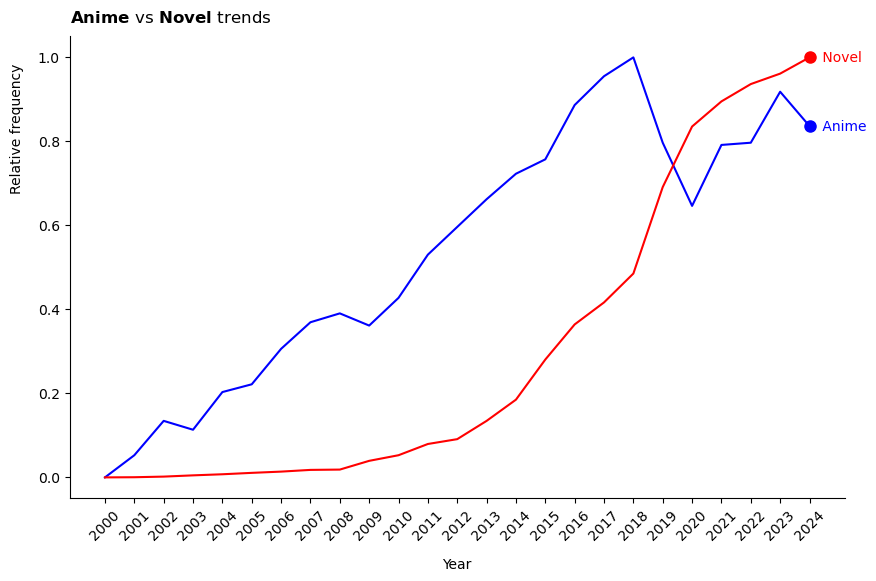

In [271]:
anime_count = anime_df["Release"].dt.year.value_counts().sort_index()

anime_norm = helpers.nmm(anime_count)
novel_norm = helpers.nmm(novel_count)

plt.figure(figsize=(10,6))

anime_norm.plot(color="blue")
novel_norm.plot(color="red")

plt.title(r"$\bf{Anime}$ vs $\bf{Novel}$ trends", fontsize=12, loc="left", pad=10)
plt.xlabel("Year", fontsize=10, labelpad=10)
plt.ylabel("Relative frequency", fontsize=10, labelpad=10, y=0.8)

plt.xticks(anime_norm.index[:], rotation=45)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.text(anime_norm.index[-1] + 0.3, anime_norm.values[-1] - 0.01, " Anime", color="blue")
plt.text(anime_norm.index[-1] + 0.3, novel_norm.values[-1] - 0.01, " Novel", color="red")

plt.plot(anime_norm.index[-1], anime_norm.values[-1], "o", color="blue", markersize=8)
plt.plot(anime_norm.index[-1], novel_norm.values[-1], "o", color="red", markersize=8)

plt.show()

**Interpretation:** While it seems to be a growth in the novels following the growth in the anime, that does not necessarily apply to the isekai as well.

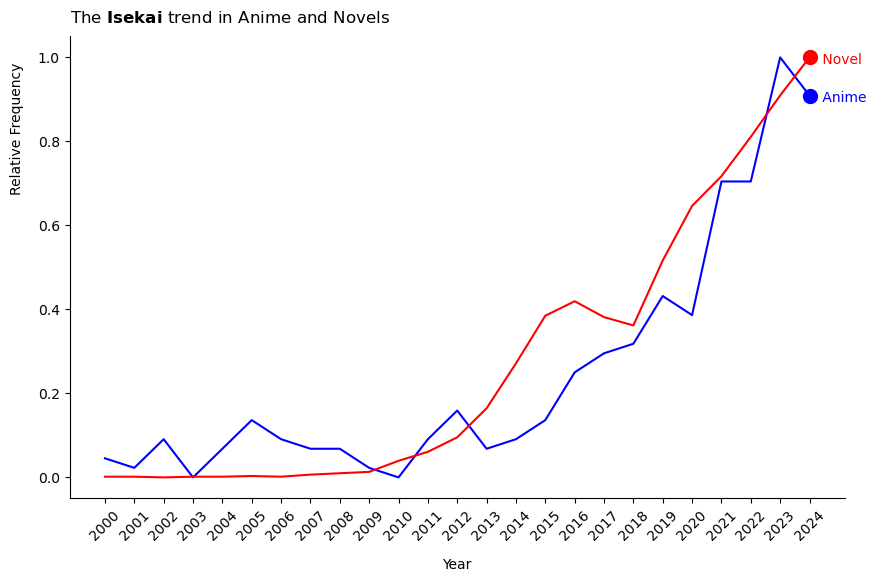

In [272]:
ianime_count = ianime_df["Release"].dt.year.value_counts().sort_index()

ianime_norm = helpers.nmm(ianime_count)
inovel_norm = helpers.nmm(inovel_count)

plt.figure(figsize=(10,6))
ianime_norm.plot(color="blue")
inovel_norm.plot(color="red")

plt.title(r"The $\bf{Isekai}$ trend in Anime and Novels", loc="left", fontsize=12, pad=10)
plt.xlabel("Year", labelpad=10, fontsize=10)
plt.ylabel("Relative Frequency", y=0.8, labelpad=10, fontsize=10)

plt.xticks(ianime_norm.index[:], rotation=45)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.plot(ianime_norm.index[-1], ianime_norm.values[-1], marker="o", markersize=10, color="blue")
plt.plot(ianime_norm.index[-1], inovel_norm.values[-1], marker="o", markersize=10, color="red")

plt.text(ianime_norm.index[-1] + 0.3, ianime_norm.values[-1] - 0.015, " Anime", color="blue")
plt.text(ianime_norm.index[-1] + 0.3, inovel_norm.values[-1] - 0.015, " Novel", color="red")

plt.show()

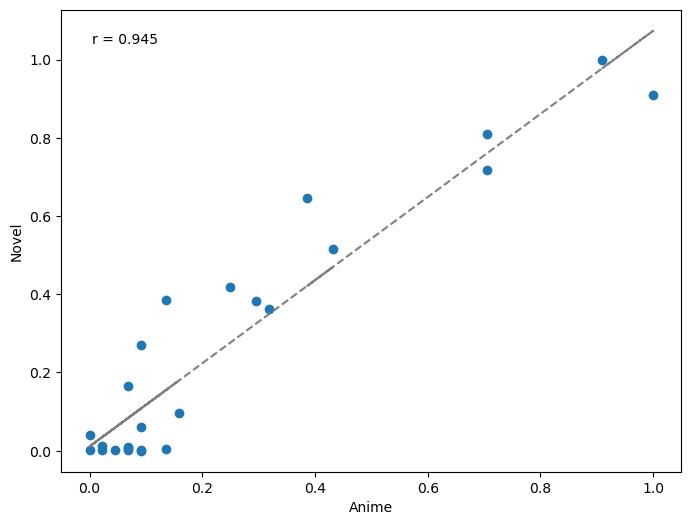

In [273]:
x = ianime_norm.values
y = inovel_norm.values

coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)

correlation1 = ianime_norm.corr(inovel_norm)

plt.figure(figsize=(8,6))
plt.scatter(x, y)
plt.plot(x, trendline(x), color="grey", linestyle="--")
plt.xlabel("Anime")
plt.ylabel("Novel")
plt.text(0.05, 0.95, f'r = {correlation1:.3f}', transform=plt.gca().transAxes, 
         verticalalignment='top')
plt.show()

**Observation:** As we can see in the previous to graphs, besides the strong positive correlation there also seems to be a lag of 2 or 3 years between the growth in novels and the posterior growth in anime.

**Next step:** To put into test this we are going to do the same but with the novel shifted to years.

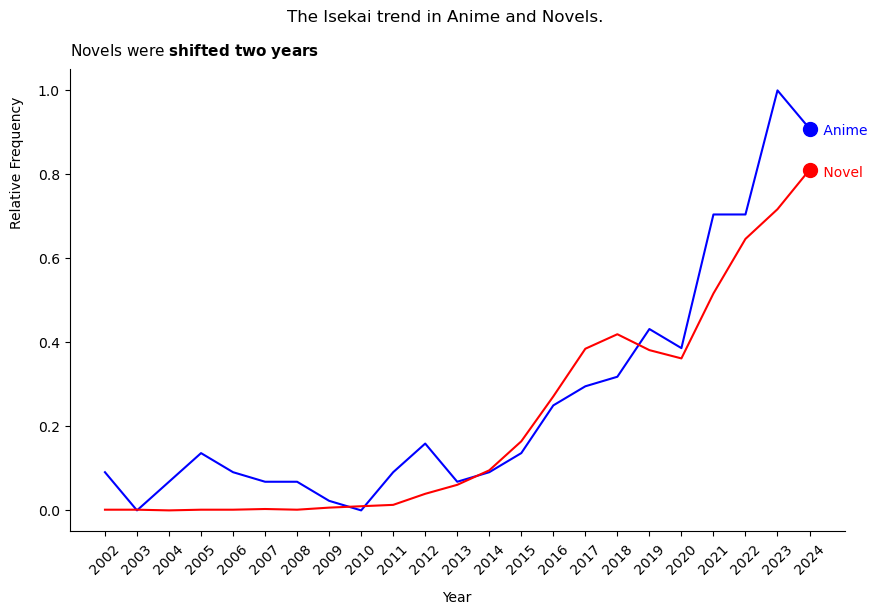

In [274]:
inovel_norm = inovel_norm.shift(2)

mask = inovel_norm.notna()
ianime_norm_s = ianime_norm[mask]
inovel_norm = inovel_norm[mask]

plt.figure(figsize=(10,6))
ianime_norm_s.plot(color="blue")
inovel_norm.plot(color="red")

plt.suptitle("The Isekai trend in Anime and Novels.", fontsize=12)
plt.title(r"Novels were $\bf{shifted}$ $\bf{two}$ $\bf{years}$", fontsize=11, loc="left", pad=10)
plt.xlabel("Year", fontsize=10, labelpad=10)
plt.ylabel("Relative Frequency", fontsize=10, labelpad=10, y=0.8)

plt.xticks(ianime_norm_s.index[:], rotation=45)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.plot(ianime_norm_s.index[-1], ianime_norm_s.values[-1], marker="o", markersize=10, color="blue")
plt.plot(ianime_norm_s.index[-1], inovel_norm.values[-1], marker="o", markersize=10, color="red")

plt.text(ianime_norm_s.index[-1] + 0.3, ianime_norm_s.values[-1] - 0.015, " Anime", color="blue")
plt.text(ianime_norm_s.index[-1] + 0.3, inovel_norm.values[-1] - 0.015, " Novel", color="red")

plt.show()

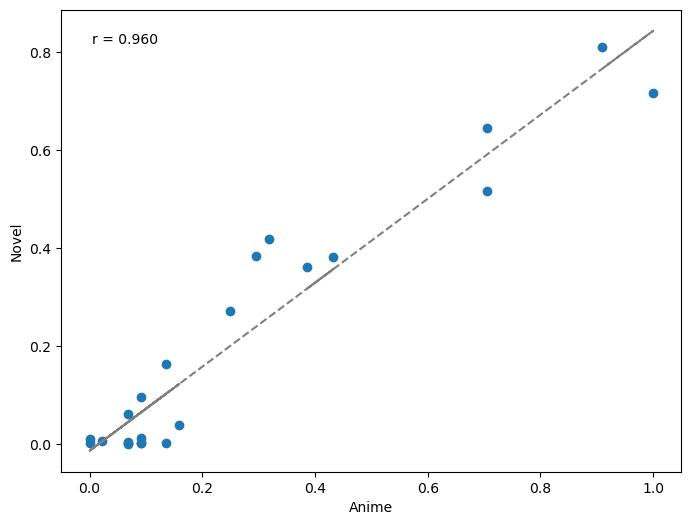

In [275]:
x = ianime_norm_s.values
y = inovel_norm.values

coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)

correlation2 = ianime_norm_s.corr(inovel_norm)

plt.figure(figsize=(8,6))
plt.scatter(x, y)
plt.plot(x, trendline(x), color="grey", linestyle="--")
plt.xlabel("Anime")
plt.ylabel("Novel")
plt.text(0.05, 0.95, f'r = {correlation2:.3f}', transform=plt.gca().transAxes, 
         verticalalignment='top')
plt.show()

**Observation:** There is clearly a bigger correlation when the novel is shifted 2 years, going from **0.945** to **0.960**. In addition, there also seem to be different periods, **2010-2024** and **2020-2024**, where in the first the novel leads, and in the second anime overtakes.

This could mean that initially, the growth in novels led to the anime boom, but once isekai became popular, it's actually anime driving the release of more novels.

**Next step:** We are going to do the same with manga in order to explore the possibiity that not only novel, but also manga drove the anime's growth, especially in recent years.

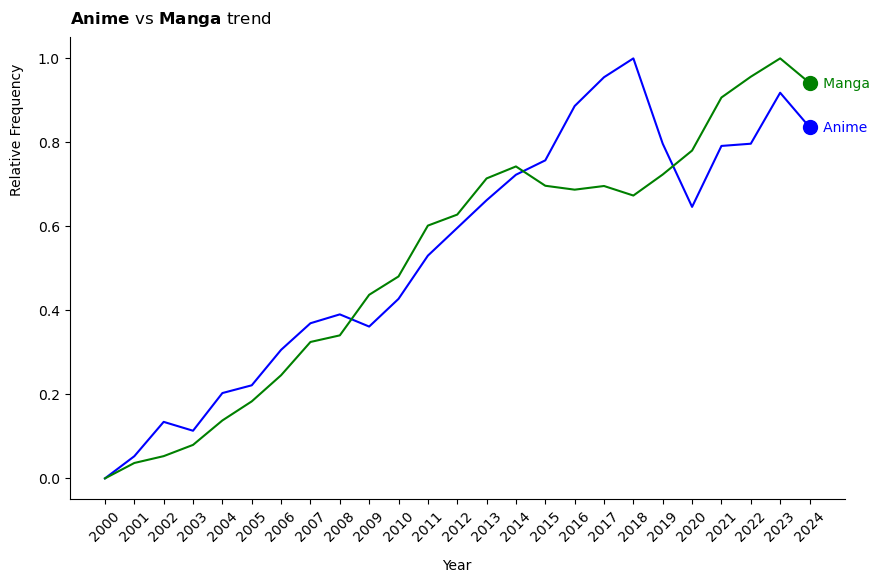

In [276]:
manga_count = manga_df["publishing_date"].dt.year.value_counts().sort_index()

manga_norm = helpers.nmm(manga_count)

plt.figure(figsize=(10,6))
anime_norm.plot(color="blue")
manga_norm.plot(color="green")

plt.title(r"$\bf{Anime}$ vs $\bf{Manga}$ trend", loc="left", pad=10, fontsize=12)
plt.xlabel("Year", fontsize=10, labelpad=10)
plt.ylabel("Relative Frequency", y=0.8, fontsize=10, labelpad=10)
plt.xticks(anime_norm.index[:], rotation=45)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.plot(anime_norm.index[-1], anime_norm.values[-1], marker="o", markersize=10, color="blue")
plt.plot(anime_norm.index[-1], manga_norm.values[-1], marker="o", markersize=10, color="green")

plt.text(anime_norm.index[-1], anime_norm.values[-1] - 0.01, "   Anime", color="blue")
plt.text(anime_norm.index[-1], manga_norm.values[-1] - 0.01, "   Manga", color="green")

plt.show()

**Observation:** This time seems to be a strong correlation, unlike novel, but once again it does not necessarily means that it will be the same for isekai.

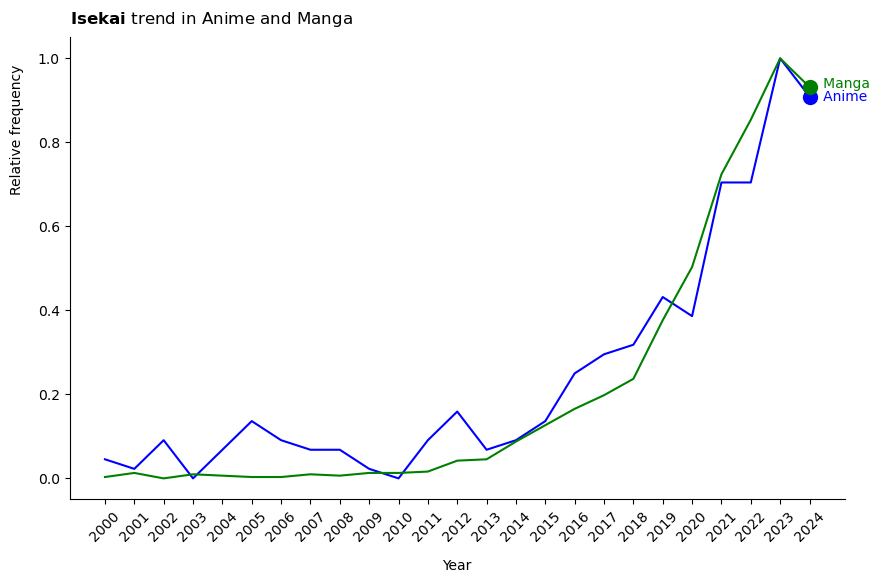

In [277]:
imanga_count = imanga_df["publishing_date"].dt.year.value_counts()
imanga_count.loc[2002] = 0
imanga_count = imanga_count.sort_index()

imanga_norm = helpers.nmm(imanga_count)

plt.figure(figsize=(10,6))
ianime_norm.plot(color="blue")
imanga_norm.plot(color="green")

plt.title(r"$\bf{Isekai}$ trend in Anime and Manga", loc="left", fontsize=12, pad=10)
plt.xlabel("Year", labelpad=10, fontsize=10)
plt.ylabel("Relative frequency", y=0.8, fontsize=10, labelpad=10)
plt.xticks(ianime_norm.index[:], rotation=45)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.plot(ianime_norm.index[-1], ianime_norm.values[-1], marker="o", markersize=10, color="blue")
plt.plot(ianime_norm.index[-1], imanga_norm.values[-1], marker="o", markersize=10, color="green")

plt.text(ianime_norm.index[-1], ianime_norm.values[-1] - 0.01, "   Anime", color="blue")
plt.text(ianime_norm.index[-1], imanga_norm.values[-1], "   Manga", color="green")

plt.show()

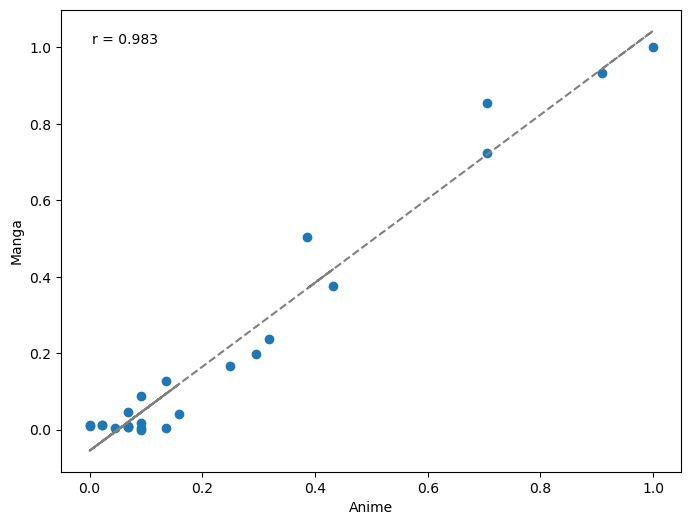

In [278]:
x = ianime_norm.values
y = imanga_norm.values

coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)

correlation1 = ianime_norm.corr(imanga_norm)

plt.figure(figsize=(8,6))
plt.scatter(x, y)
plt.plot(x, trendline(x), color="grey", linestyle="--")
plt.xlabel("Anime")
plt.ylabel("Manga")
plt.text(0.05, 0.95, f'r = {correlation1:.3f}', transform=plt.gca().transAxes, 
         verticalalignment='top')
plt.show()

**Observation:** There is clearly a strong positive correlation, but unlike with novels, there does not seem to be any causality. Instead, it seems like both of them react to the same phenomenon in the same way. Besides, as you will see in the next table, manga as a source has never become relevant for isekai anime

In [279]:
pivot = ianime_df.pivot_table(  
    index=ianime_df["Release"].dt.year,
    columns="Source",
    aggfunc="size",
    fill_value=0
)
pivot = pivot[["Light novel", "Manga", "Original"]]
pivot

Source,Light novel,Manga,Original
Release,,,
2000,0,0,2
2001,0,1,1
2002,0,1,2
2003,0,0,0
2004,1,1,1
2005,1,3,0
2006,1,1,1
2007,2,0,1
2008,4,0,0


### 19. Insights.

We can conclude that one of the reasons behind the isekai sub-genre's growth in the anime industry is due to its growth in light novels. Furthermore, it seems that manga did not have such importance; rather, it reacted to the phenomenon along with anime.